In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys

sys.path.append("../")

In [3]:
from src.epl_player_data_utils import EPLPlayerData

epl_player_data = EPLPlayerData("../SampleData/players.json")
epl_player_data

EPLPlayerData(../SampleData/players.json): 804 players

In [76]:
shots_dataset = pd.read_csv("shots_dataset.csv").drop(columns=["lineup_id"])
shots_dataset

,player_id,team_id,match_id,match_num,shots_ratio
0,0.0,0,441999,0,0.000000
1,0.0,0,441999,0,0.000000
2,17733.0,0,441999,0,0.032249
3,19524.0,0,441999,0,0.016125
4,15943.0,0,441999,0,0.016125
...,...,...,...,...,...
41920,76227.0,1,442378,379,0.000000
41921,50471.0,1,442378,379,0.000000
41922,125510.0,1,442378,379,0.000000
41923,0.0,1,442378,379,0.000000


In [77]:
players = shots_dataset["player_id"].unique().astype(int)
player_pos = {player: epl_player_data.get_player_position(player) for player in players}

shots_dataset["player_position"] = shots_dataset["player_id"].apply(lambda x: player_pos[x])
shots_dataset

,player_id,team_id,match_id,match_num,shots_ratio,player_position
0,0.0,0,441999,0,0.000000,None
1,0.0,0,441999,0,0.000000,None
2,17733.0,0,441999,0,0.032249,F
3,19524.0,0,441999,0,0.016125,M
4,15943.0,0,441999,0,0.016125,D
...,...,...,...,...,...,...
41920,76227.0,1,442378,379,0.000000,M
41921,50471.0,1,442378,379,0.000000,M
41922,125510.0,1,442378,379,0.000000,F
41923,0.0,1,442378,379,0.000000,None


In [78]:
shots_dataset_non_zero = shots_dataset[shots_dataset["shots_ratio"] > 0]
shots_dataset_non_zero

,player_id,team_id,match_id,match_num,shots_ratio,player_position
2,17733.0,0,441999,0,0.032249,F
3,19524.0,0,441999,0,0.016125,M
4,15943.0,0,441999,0,0.016125,D
5,20467.0,0,441999,0,0.016125,F
9,17127.0,0,441999,0,0.032249,D
...,...,...,...,...,...,...
41867,3296.0,1,442378,379,0.014918,D
41868,50023.0,1,442378,379,0.014918,M
41869,74235.0,1,442378,379,0.014918,D
41871,50471.0,1,442378,379,0.029836,M


<Axes: xlabel='player_position'>

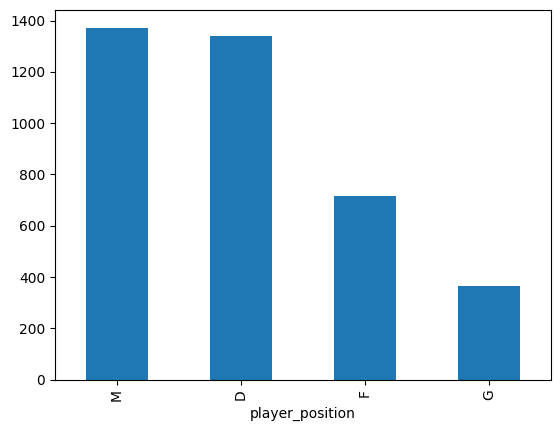

In [79]:
shots_dataset_non_zero["player_position"].value_counts().plot(kind="bar")

In [80]:
shots_dataset_enc = pd.get_dummies(shots_dataset_non_zero, columns=["player_position"])
shots_dataset_enc

,player_id,team_id,match_id,match_num,shots_ratio,player_position_D,player_position_F,player_position_G,player_position_M
2,17733.0,0,441999,0,0.032249,False,True,False,False
3,19524.0,0,441999,0,0.016125,False,False,False,True
4,15943.0,0,441999,0,0.016125,True,False,False,False
5,20467.0,0,441999,0,0.016125,False,True,False,False
9,17127.0,0,441999,0,0.032249,True,False,False,False
...,...,...,...,...,...,...,...,...,...
41867,3296.0,1,442378,379,0.014918,True,False,False,False
41868,50023.0,1,442378,379,0.014918,False,False,False,True
41869,74235.0,1,442378,379,0.014918,True,False,False,False
41871,50471.0,1,442378,379,0.029836,False,False,False,True


In [81]:
# Last 111 Match IDs are test set
train_set = shots_dataset_enc[shots_dataset_enc["match_num"] <= 379 - 111]
test_set = shots_dataset_enc[shots_dataset_enc["match_num"] > 379 - 111]

train_set["match_num"].unique().shape, test_set["match_num"].unique().shape

((269,), (111,))

In [82]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np

Train MSE: 0.004421086713284054, Test MSE: 0.002342688228721867


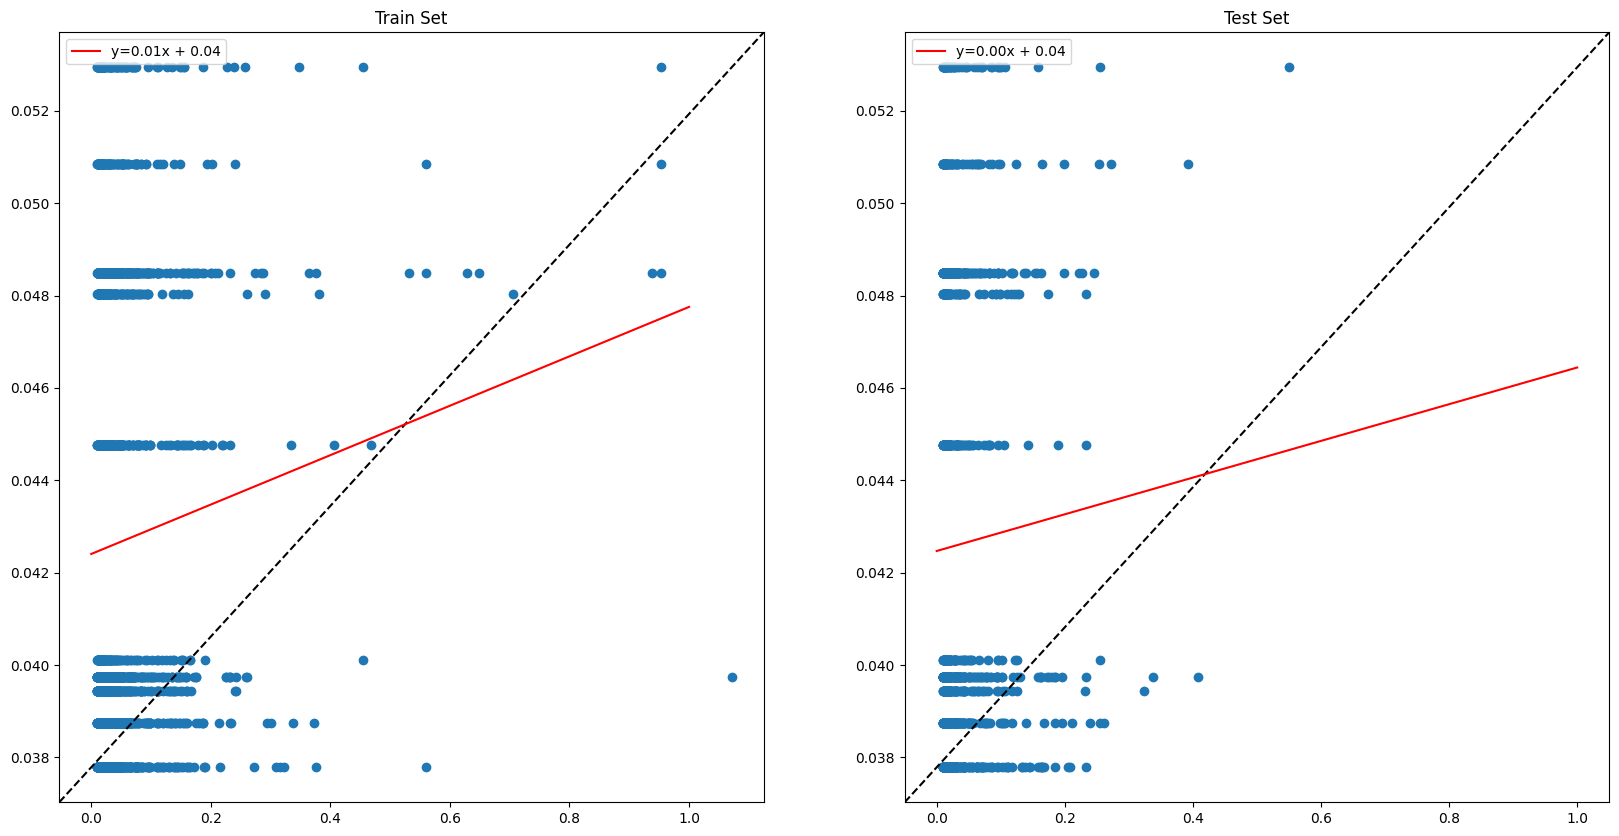

In [93]:
def fit_xgb_model(train_set, target_column, drop_columns):
    model = xgb.XGBRegressor(objective="reg:squarederror")
    model.fit(train_set.drop(columns=drop_columns), train_set[target_column])
    return model


def predict_and_evaluate(model, data_set, target_column, drop_columns):
    preds = model.predict(data_set.drop(columns=drop_columns))
    mse = mean_squared_error(data_set[target_column], preds)
    return preds, mse


def plot_scatter_with_regression(ax, x, y, title):
    ax.scatter(x, y)
    ax.set_title(title)
    # Plot y=x line
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black")
    # Plot regression line using linear regression
    lr_model = LinearRegression()
    lr_model.fit(x.values.reshape(-1, 1), y)
    x_line = np.linspace(0, 1, 100)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    ax.plot(
        x_line,
        lr_model.predict(x_line.reshape(-1, 1)),
        color="red",
        label=f"y={slope:.2f}x + {intercept:.2f}",
    )
    ax.legend()


# Datos de entrada
target_column = "shots_ratio"
drop_columns = ["shots_ratio", "match_id", "player_id", "match_num"]

# Ajustar el modelo XGBoost
xgb_model = fit_xgb_model(train_set, target_column, drop_columns)

# Predecir y evaluar el modelo
train_preds, train_mse = predict_and_evaluate(
    xgb_model, train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    xgb_model, test_set, target_column, drop_columns
)

# Mostrar MSE
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

# Graficar los resultados
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], test_set[target_column], test_preds, "Test Set")

plt.show()

Train MSE: 0.004426178311705898, Test MSE: 0.0023298316175847746


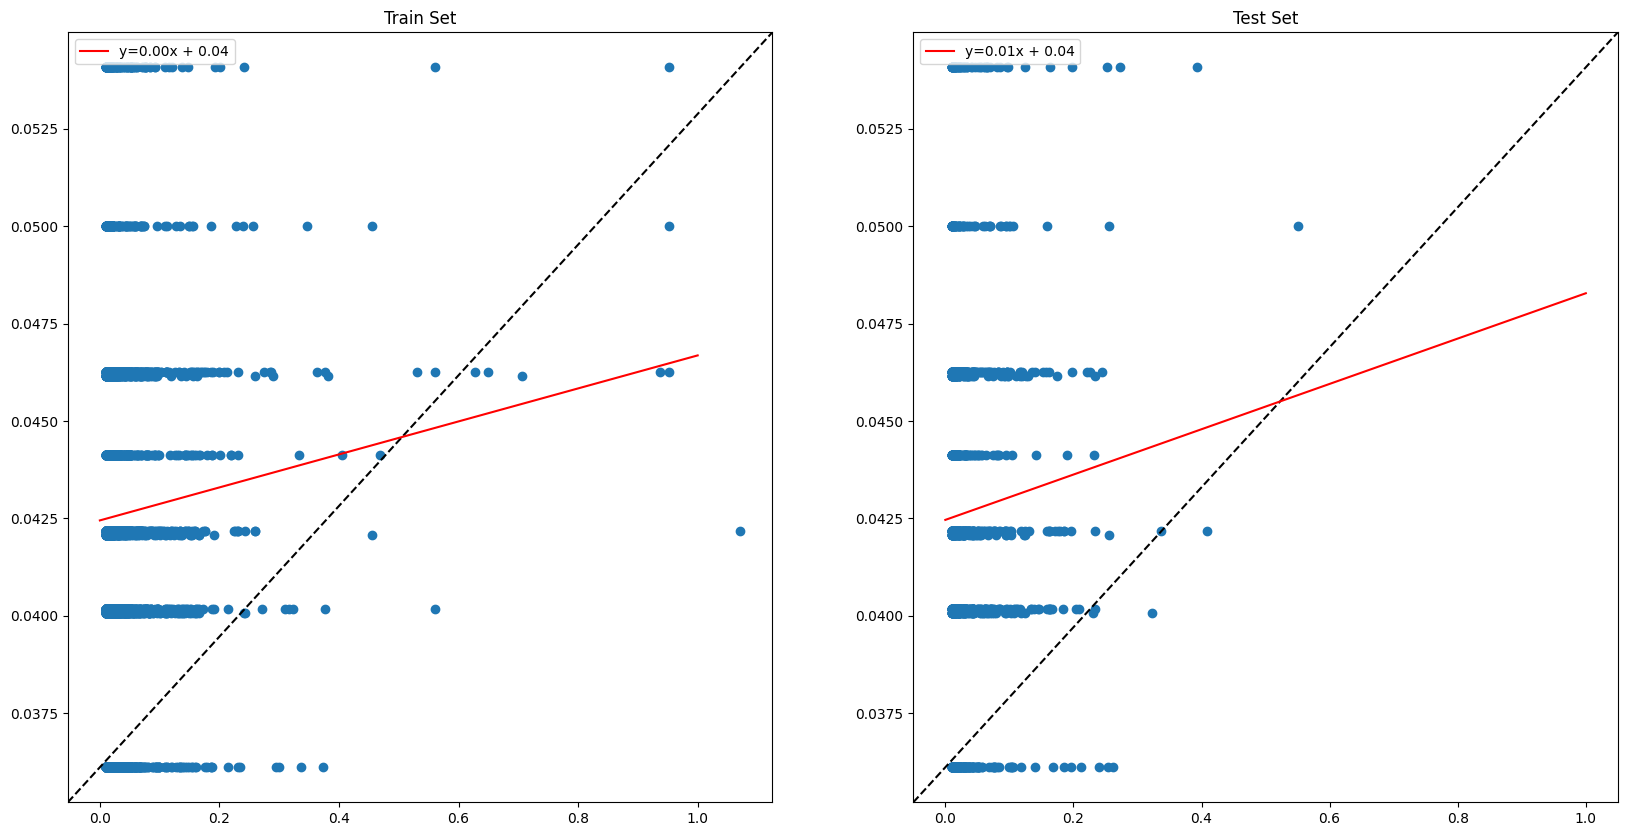

In [94]:
lr_model = LinearRegression()
lr_model.fit(train_set.drop(columns=drop_columns), train_set[target_column])

train_preds, train_mse = predict_and_evaluate(
    lr_model, train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    lr_model, test_set, target_column, drop_columns
)

print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], test_set[target_column], test_preds, "Test Set")

plt.show()

Text(0.5, 1.0, 'Linear Regression Model')

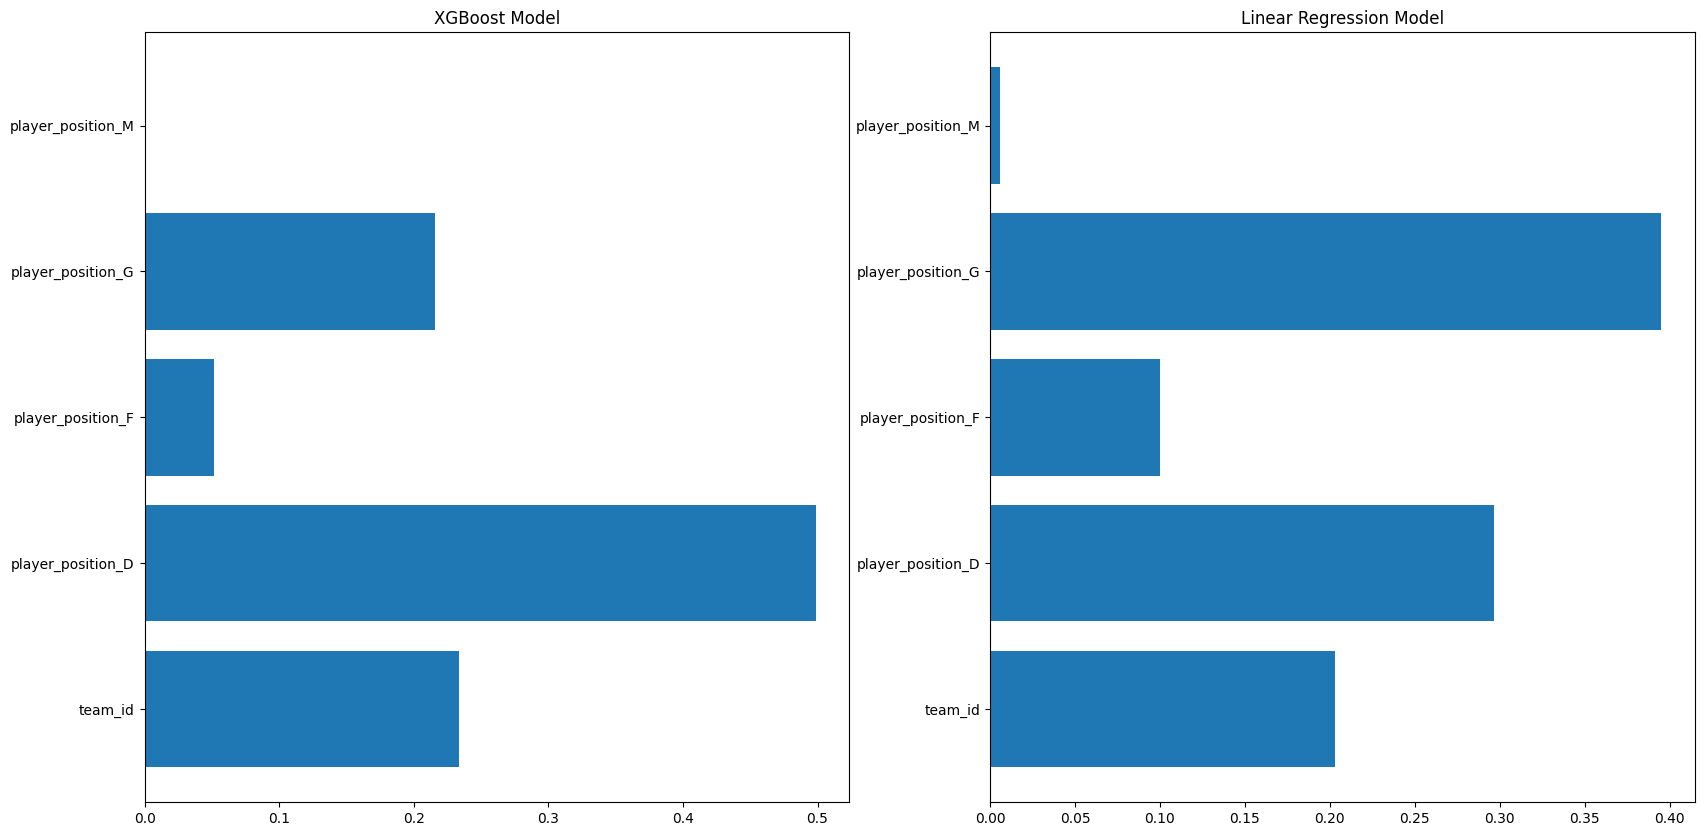

In [95]:
# Feature importance
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

xgb_importance = xgb_model.feature_importances_
xgb_importance /= xgb_importance.sum()
ax[0].barh(train_set.drop(columns=drop_columns).columns, xgb_importance)
ax[0].set_title("XGBoost Model")

lr_importance = np.abs(lr_model.coef_)
lr_importance /= lr_importance.sum()
ax[1].barh(train_set.drop(columns=drop_columns).columns, lr_importance)
ax[1].set_title("Linear Regression Model")

In [86]:
def load_player_features_dataframe(filepath):
    # Load the DataFrame from disk
    return pd.read_parquet(filepath)


def get_features_from_df(player_id, match_id, features_df, cols):
    return features_df.loc[(player_id, match_id)][cols].to_dict()
    # try:
    # except KeyError:
    #     return {col: 0 for col in cols}


player_features_df = load_player_features_dataframe("player_features_optimized.parquet")

In [87]:
list(player_features_df.iloc[0].index)

['pases/90', 'shots/90', 'losses/90', 'gains/90', 'minutes', 'match_date']

In [88]:
# Copiar el DataFrame original
ds_w_features = shots_dataset_enc.copy()

# Aplicar la función y expandir el diccionario en nuevas columnas
feature_cols = []

for row in ds_w_features.itertuples():
    player_id = row.player_id
    match_id = row.match_id
    features = get_features_from_df(
        player_id,
        match_id,
        player_features_df,
        ["pases/90", "shots/90", "losses/90", "gains/90", "minutes", "match_date"],
    )
    for col, value in features.items():
        ds_w_features.at[row.Index, col] = value

# Verificar el resultado
ds_w_features.head()

,player_id,team_id,match_id,match_num,shots_ratio,player_position_D,player_position_F,player_position_G,player_position_M,pases/90,shots/90,losses/90,gains/90,minutes,match_date
2,17733.0,0,441999,0,0.032249,False,True,False,False,0.0,0.0,0.0,0.0,0.0,2012-08-18
3,19524.0,0,441999,0,0.016125,False,False,False,True,0.0,0.0,0.0,0.0,0.0,2012-08-18
4,15943.0,0,441999,0,0.016125,True,False,False,False,0.0,0.0,0.0,0.0,0.0,2012-08-18
5,20467.0,0,441999,0,0.016125,False,True,False,False,0.0,0.0,0.0,0.0,0.0,2012-08-18
9,17127.0,0,441999,0,0.032249,True,False,False,False,0.0,0.0,0.0,0.0,0.0,2012-08-18


In [92]:
# Model with player features

# Last 111 Match IDs are test set
f_train_set = ds_w_features[ds_w_features["match_num"] <= 379 - 111]
f_test_set = ds_w_features[ds_w_features["match_num"] > 379 - 111]

In [97]:
train_set

,player_id,team_id,match_id,match_num,shots_ratio,player_position_D,player_position_F,player_position_G,player_position_M
2,17733.0,0,441999,0,0.032249,False,True,False,False
3,19524.0,0,441999,0,0.016125,False,False,False,True
4,15943.0,0,441999,0,0.016125,True,False,False,False
5,20467.0,0,441999,0,0.016125,False,True,False,False
9,17127.0,0,441999,0,0.032249,True,False,False,False
...,...,...,...,...,...,...,...,...,...
29721,3332.0,1,442267,268,0.015617,True,False,False,False
29732,14278.0,1,442267,268,0.056444,True,False,False,False
29735,39253.0,1,442267,268,0.056444,True,False,False,False
29737,3332.0,1,442267,268,0.112888,True,False,False,False


Train MSE: 0.000972132725981955, Test MSE: 0.0028769431079766782


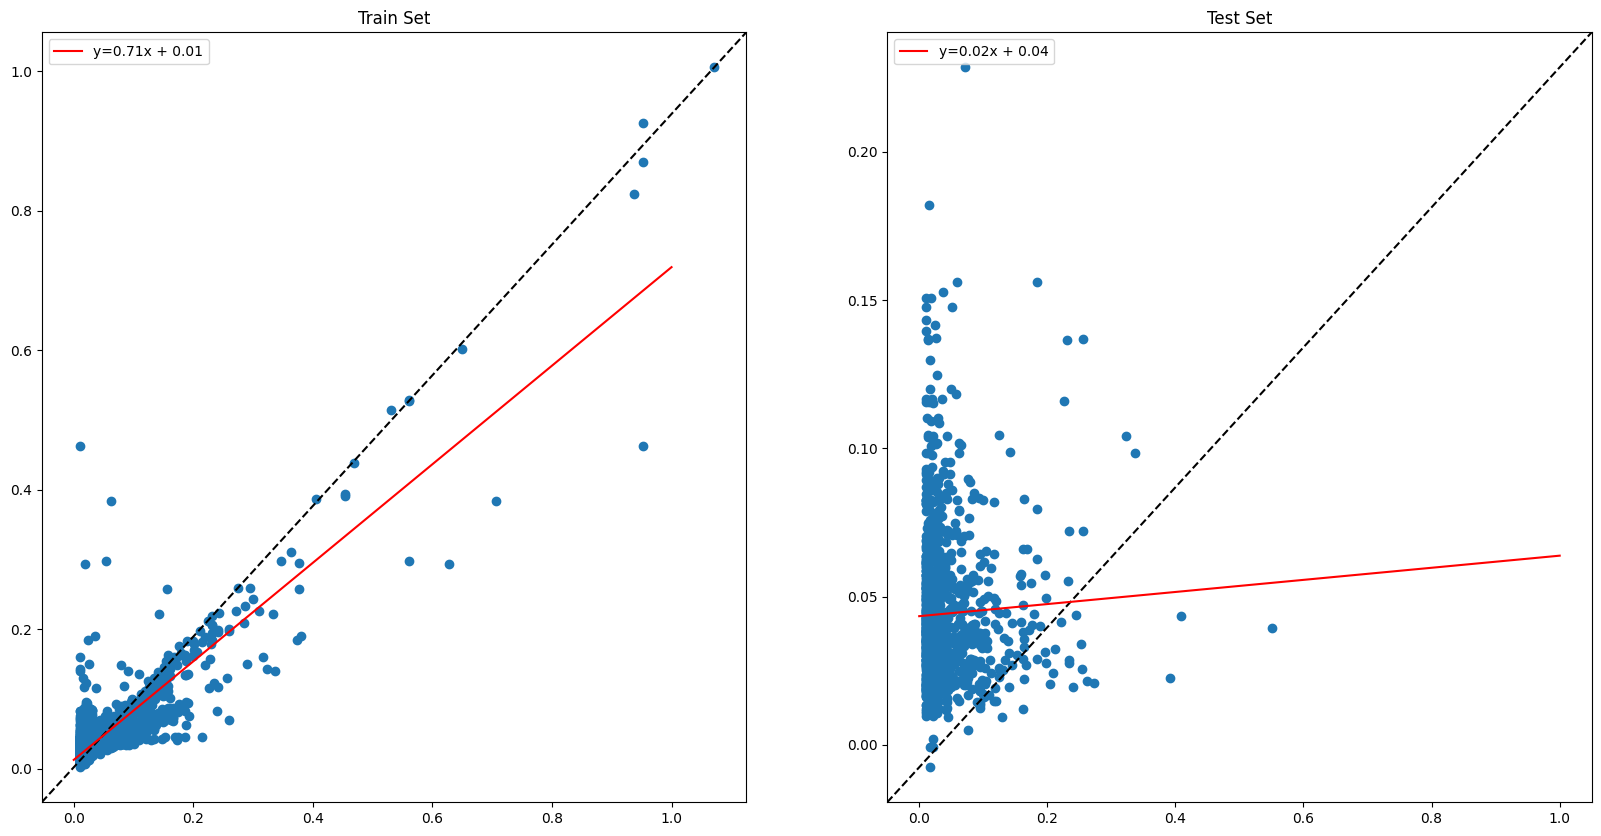

In [98]:
# Datos de entrada
target_column = "shots_ratio"
drop_columns = ["shots_ratio", "match_id", "player_id", "match_date", "match_num"]

# Ajustar el modelo XGBoost
xgb_model = fit_xgb_model(f_train_set, target_column, drop_columns)

# Predecir y evaluar el modelo
train_preds, train_mse = predict_and_evaluate(
    xgb_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    xgb_model, f_test_set, target_column, drop_columns
)

# Mostrar MSE
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

# Graficar los resultados
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], f_train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], f_test_set[target_column], test_preds, "Test Set")

plt.show()


Train MSE: 0.004408361330072862, Test MSE: 0.002326646436830458


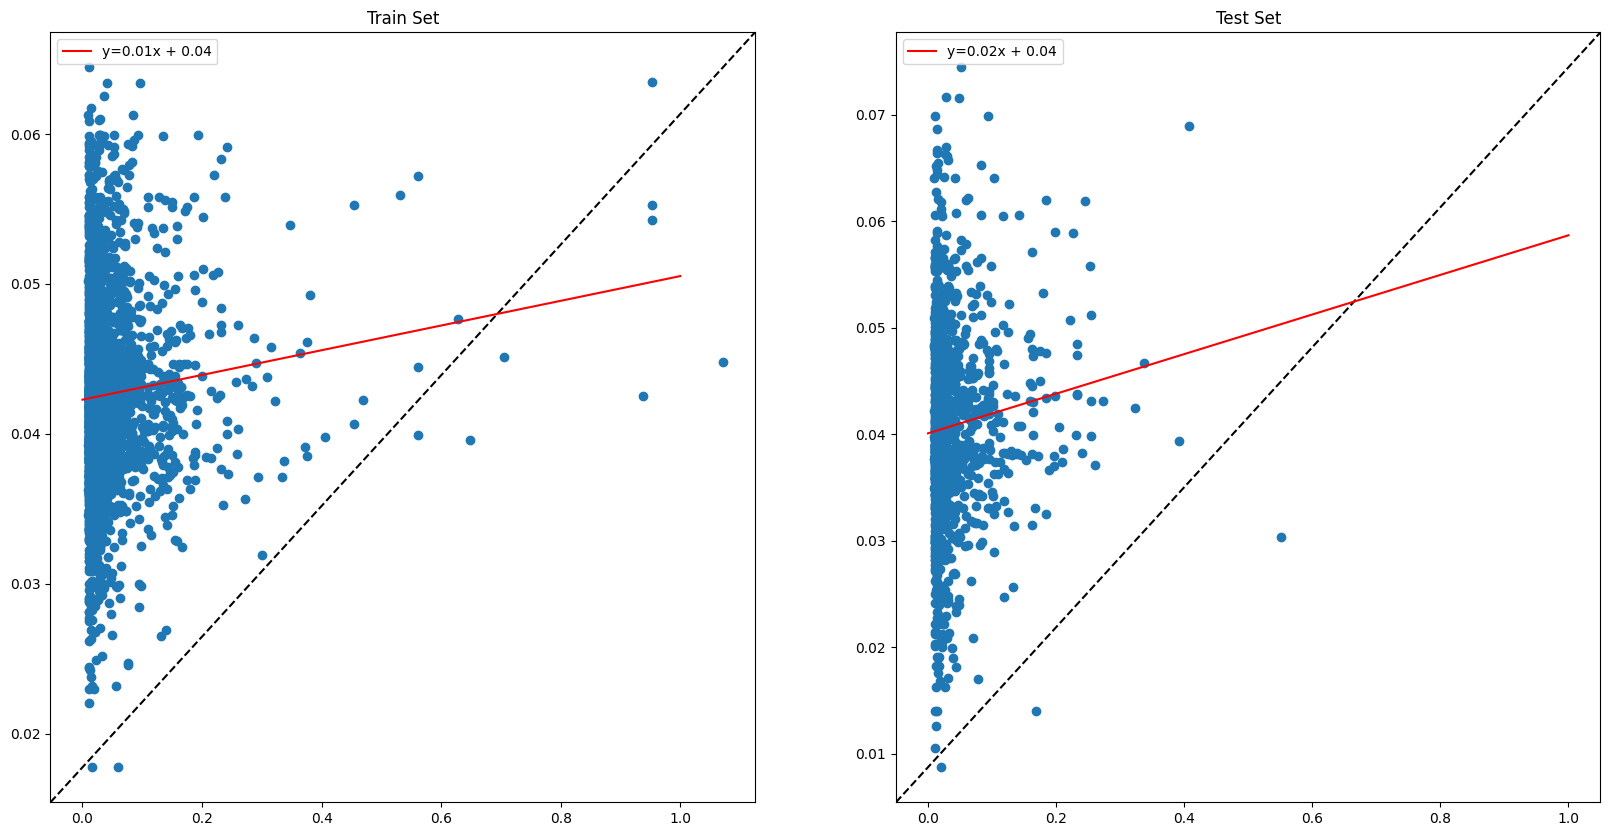

In [99]:
lr_model = LinearRegression()

lr_model.fit(f_train_set.drop(columns=drop_columns), f_train_set[target_column])

train_preds, train_mse = predict_and_evaluate(
    lr_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    lr_model, f_test_set, target_column, drop_columns
)

print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], f_train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], f_test_set[target_column], test_preds, "Test Set")

plt.show()

<BarContainer object of 10 artists>

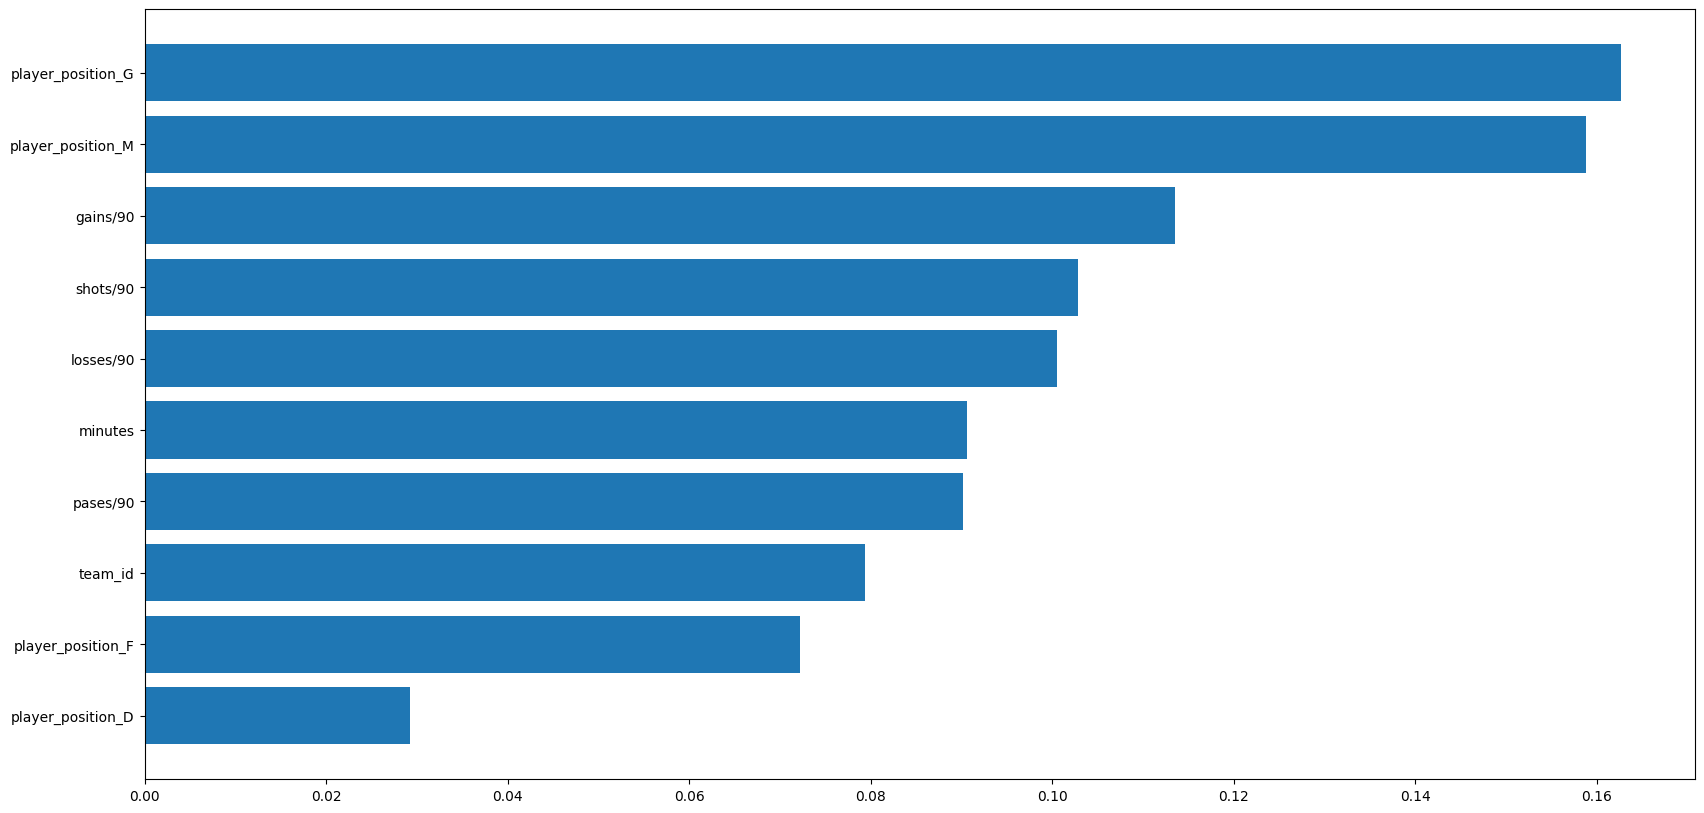

In [105]:
# Feature importance

fig, ax = plt.subplots(figsize=(20, 10))

xgb_importance = xgb_model.feature_importances_
xgb_importance /= xgb_importance.sum()

importances = pd.Series(xgb_importance, index=f_train_set.drop(columns=drop_columns).columns).sort_values(ascending=True)

ax.barh(importances.index, importances)


In [110]:
# XGBoost Hiperparameter Tuning

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "max_depth": [3, 5, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [50, 100, 200, 250],
    "subsample": [0.5, 0.7, 0.9, 1],
    "colsample_bytree": [0.5, 0.7, 0.9, 1],
    "gamma": [0, 1, 5, 10],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0, 0.1, 0.5, 1],
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

rs = RandomizedSearchCV(
    xgb_model,
    param_dist,
    n_iter=500,
    cv=2,
    n_jobs=-1,
    verbose=1,
    scoring="neg_mean_squared_error",
)

rs.fit(f_train_set.drop(columns=drop_columns), f_train_set[target_column])

Fitting 2 folds for each of 500 candidates, totalling 1000 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9, 1],
                                        'gamma': [0, 1, 5, 10],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 5, 10, 15, 20],
                                        'n_estimators': [50, 100, 200, 250],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.5, 0.7, 0.9, 1]},
                   scoring='neg_mean_squared_error', verbose=1)

In [111]:
rs.best_params_

{'subsample': 0.5,
 'reg_lambda': 1,
 'reg_alpha': 1,
 'n_estimators': 50,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.7}

Train MSE: 0.004332520899075433, Test MSE: 0.002337470309674719


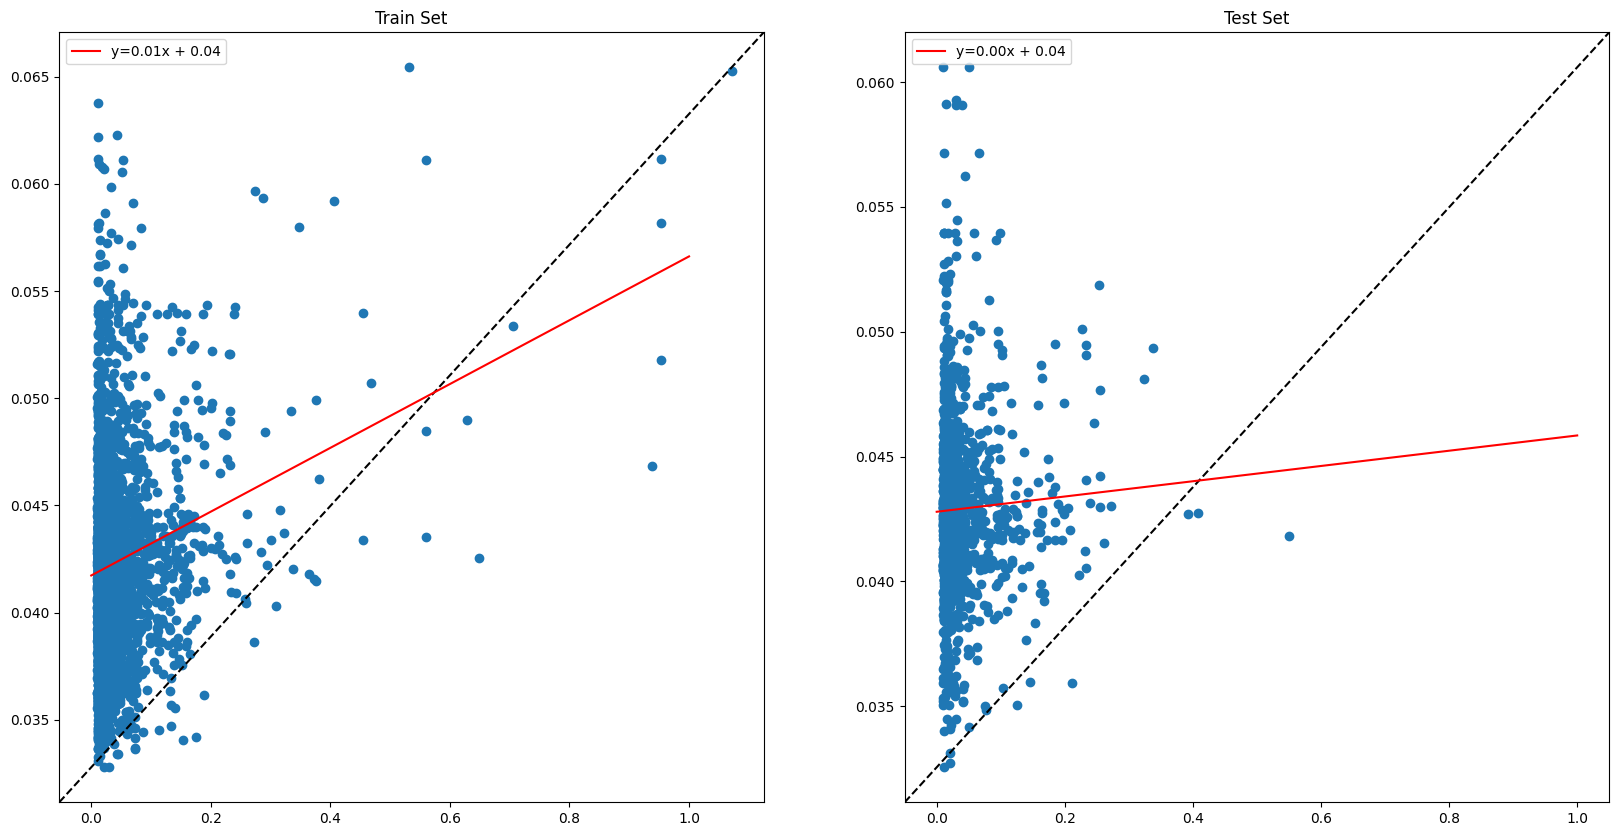

In [112]:
rs_model = rs.best_estimator_

train_preds, train_mse = predict_and_evaluate(
    rs_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    rs_model, f_test_set, target_column, drop_columns
)

print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(
    ax[0], f_train_set[target_column], train_preds, "Train Set"
)
plot_scatter_with_regression(ax[1], f_test_set[target_column], test_preds, "Test Set")

plt.show()